# Vigilant Asset Allocation (VAA)

Vigilant Asset Allocation (VAA) is introduced by Wouter J. Keller and Jan Willem Keuning in research paper "Breadth Momentum and Vigilant Asset Allocation (VAA): Winning More by Losing Less" (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3002624)

VAA strategy is an upgraded version of dual momentum with fast filter. 

1. We buy the strongest asset in terms of momentum in offensive assets.
2. If the most recent return of any of the offensive assets is negative, we go to defensive asset.

When it comes to computing returns' weights, it emphasizes the most recent 1 month return.

recent_return = 12 * (recent 1M return) + 4 * (recent 4M return) + 2 * (recent 6M return) + 1 * (recent 12M return)

In [1]:
import numpy as np
import pandas as pd
import src.fmp as fmp
import datetime as dt
import matplotlib.pyplot as plt

## Portfolio Assets

In [2]:
offensive = ['SPY', 'VEA', 'VWO', 'AGG']
defensive = ['SHY', 'IEF', 'LQD']

## Calculate monthly prices of offensive assets

In [3]:
offensive_monthly = pd.DataFrame()

for symbol in offensive:
    offensive_monthly[symbol] = fmp.get_monthly_prices(symbol)[symbol]
offensive_monthly.dropna(inplace=True)
offensive_monthly.head(20)

,SPY,VEA,VWO,AGG
2007-07-31,145.720001,47.900002,47.250000,98.989998
2007-08-31,147.589996,47.860001,47.244999,99.820000
2007-09-28,152.580002,50.139999,51.889999,100.019997
2007-10-31,154.649994,52.360001,58.639999,100.610001
2007-11-30,148.660004,50.389999,53.639999,102.000000
2007-12-31,146.210007,47.919998,52.150002,101.169998
2008-01-31,137.369995,44.380001,47.445000,103.510002
2008-02-29,133.820007,43.930000,48.810001,102.930000
2008-03-31,131.970001,44.080002,47.014999,102.680000
2008-04-30,138.259995,46.450001,50.980000,102.599998


## Offensive assets momentum

In [4]:
momentum_data = {'1M': [], '3M': [], '6M': [], '12M': []}
for symbol in offensive_monthly.columns:
    print(symbol)
    curr = offensive_monthly[symbol][-1]
    m1_ret = (curr - offensive_monthly[symbol].shift(1)[-1]) / offensive_monthly[symbol].shift(1)[-1]
    momentum_data['1M'].append(m1_ret)
    m3_ret = (curr - offensive_monthly[symbol].shift(3)[-1]) / offensive_monthly[symbol].shift(3)[-1]
    momentum_data['3M'].append(m3_ret)
    m6_ret = (curr - offensive_monthly[symbol].shift(6)[-1]) / offensive_monthly[symbol].shift(6)[-1]
    momentum_data['6M'].append(m6_ret)
    m12_ret = (curr - offensive_monthly[symbol].shift(12)[-1]) / offensive_monthly[symbol].shift(12)[-1]
    momentum_data['12M'].append(m12_ret)

SPY
VEA
VWO
AGG


In [5]:
offensive_momentum = pd.DataFrame(momentum_data, index=offensive)
offensive_momentum['Score'] = 12 * offensive_momentum['1M'] + 4 * offensive_momentum['3M'] + 2 * offensive_momentum['6M'] + 1 * offensive_momentum['12M']

## Defensive Assets Momentum

In [6]:
defensive_monthly = pd.DataFrame()

for symbol in defensive:
    defensive_monthly[symbol] = fmp.get_monthly_prices(symbol)[symbol]
defensive_monthly

,SHY,IEF,LQD
2002-07-31,81.260002,82.519997,101.989998
2002-08-30,81.610001,84.599998,105.699997
2002-09-30,82.080002,87.559998,107.349998
2002-10-31,82.160004,86.209999,106.250000
2002-11-29,81.709999,84.120003,106.489998
...,...,...,...
2021-04-30,86.279999,113.989998,131.150000
2021-05-28,86.320000,114.400002,131.710000
2021-06-30,86.160004,115.489998,134.360000
2021-07-30,86.290001,117.709999,136.010000


In [7]:
momentum_data = {'1M': [], '3M': [], '6M': [], '12M': []}
for symbol in defensive_monthly.columns:
    print(symbol)
    curr = defensive_monthly[symbol][-1]
    m1_ret = (curr - defensive_monthly[symbol].shift(1)[-1]) / defensive_monthly[symbol].shift(1)[-1]
    momentum_data['1M'].append(m1_ret)
    m3_ret = (curr - defensive_monthly[symbol].shift(3)[-1]) / defensive_monthly[symbol].shift(3)[-1]
    momentum_data['3M'].append(m3_ret)
    m6_ret = (curr - defensive_monthly[symbol].shift(6)[-1]) / defensive_monthly[symbol].shift(6)[-1]
    momentum_data['6M'].append(m6_ret)
    m12_ret = (curr - defensive_monthly[symbol].shift(12)[-1]) / defensive_monthly[symbol].shift(12)[-1]
    momentum_data['12M'].append(m12_ret)

SHY
IEF
LQD


In [8]:
defensive_momentum = pd.DataFrame(momentum_data, index=defensive)
defensive_momentum['Score'] = 12 * defensive_momentum['1M'] + 4 * defensive_momentum['3M'] + 2 * defensive_momentum['6M'] + 1 * defensive_momentum['12M']

## Backtesting

### VAA (Original Version: Offensive + Defensive)

#### Trading Logics

1. Compute vaa_momentum_scores using the function vaa_returns below.
2. If the momentum scores of all offensive assets are positive, we invest in one of the offensive assets which has the largest momentum score.
3. If any of momentum scores of offensive assets is negative, we don't invest in an offensive asset, and look at defensive assets.
4. If the momentum scores of all defensive assets are positive, we invest in one of the defensive assets which has the largest momentum score.
5. If any of momentum scores of defensive assets is negative, we don't inveset in a defensive asset, and hold cash for that month.

In [9]:
def vaa_returns(x):
    m1 = x / x.shift(1) - 1
    m3 = x / x.shift(3) - 1
    m6 = x / x.shift(6) - 1
    m12 = x / x.shift(12) - 1
    return (12 * m1 + 4 * m3 + 2 * m6 + 1 * m12) / 4

In [10]:
vaa_assets = ['SPY', 'VEA', 'VWO', 'AGG', 'SHY', 'IEF', 'LQD']
vaa_monthly_prices = pd.DataFrame()

for asset in vaa_assets:
    vaa_monthly_prices[asset] = fmp.get_monthly_prices(asset)[asset]
vaa_monthly_prices.head(10)

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
1993-01-29,43.93750,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-26,44.40625,NaN,NaN,NaN,NaN,NaN,NaN
1993-03-31,45.18750,NaN,NaN,NaN,NaN,NaN,NaN
1993-04-30,44.03125,NaN,NaN,NaN,NaN,NaN,NaN
1993-05-28,45.21875,NaN,NaN,NaN,NaN,NaN,NaN
1993-06-30,45.06250,NaN,NaN,NaN,NaN,NaN,NaN
1993-07-30,44.84375,NaN,NaN,NaN,NaN,NaN,NaN
1993-08-31,46.56250,NaN,NaN,NaN,NaN,NaN,NaN
1993-09-30,45.93750,NaN,NaN,NaN,NaN,NaN,NaN
1993-10-29,46.84375,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
vaa_monthly_mom = vaa_monthly_prices.copy()
vaa_monthly_mom = vaa_monthly_mom.apply(vaa_returns, axis=0)
vaa_monthly_mom.dropna(inplace=True)

In [12]:
for date in vaa_monthly_mom.index:
    if (vaa_monthly_mom.loc[date,['SPY', 'VEA', 'VWO', 'AGG']] < 0).any():
        # check defensive assets
        vaa_monthly_mom.loc[date, 'SPY'] = 0
        vaa_monthly_mom.loc[date, 'VEA'] = 0
        vaa_monthly_mom.loc[date, 'VWO'] = 0
        vaa_monthly_mom.loc[date, 'AGG'] = 0
        if (vaa_monthly_mom.loc[date,['SHY', 'IEF', 'LQD']] < 0).any():
            # hold cash
            vaa_monthly_mom.loc[date, 'SHY'] = 0
            vaa_monthly_mom.loc[date, 'IEF'] = 0
            vaa_monthly_mom.loc[date, 'LQD'] = 0
    else:
        # invest offensive asset
        vaa_monthly_mom.loc[date, 'SHY'] = 0
        vaa_monthly_mom.loc[date, 'IEF'] = 0
        vaa_monthly_mom.loc[date, 'LQD'] = 0
vaa_monthly_mom

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
2008-07-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2008-08-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2008-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2008-10-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2008-11-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...
2021-04-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2021-05-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2021-06-30,0.306842,0.125258,0.202049,0.015415,0.000000,0.00000,0.000000
2021-07-30,0.000000,0.000000,0.000000,0.000000,0.003025,0.07602,0.071181


In [13]:
mom_rank = vaa_monthly_mom.rank(axis=1, ascending=False)
for symbol in mom_rank.columns:
    mom_rank[symbol] = np.where(mom_rank[symbol] == 1, 1, 0)
mom_rank

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
2008-07-31,0,0,0,0,0,0,0
2008-08-29,0,0,0,0,0,0,0
2008-09-30,0,0,0,0,0,0,0
2008-10-31,0,0,0,0,0,0,0
2008-11-28,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2021-04-30,0,0,0,0,0,0,0
2021-05-28,0,0,0,0,0,0,0
2021-06-30,1,0,0,0,0,0,0
2021-07-30,0,0,0,0,0,1,0


In [14]:
# we have to shift the returns upward by one to align with momentum signal above.
vaa_monthly_rets = vaa_monthly_prices.pct_change()
vaa_monthly_rets.dropna(inplace=True)
vaa_monthly_rets = vaa_monthly_rets[mom_rank.index[0]:].shift(-1)
vaa_monthly_rets

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
2008-07-31,0.015454,-0.040058,-0.079166,0.003386,0.001445,0.011773,-0.003157
2008-08-29,-0.099387,-0.115887,-0.155869,-0.021439,0.004931,-0.004699,-0.111342
2008-09-30,-0.165187,-0.205573,-0.272649,-0.026676,0.007659,-0.012028,-0.023833
2008-10-31,-0.069607,-0.066213,-0.086474,0.025948,0.007126,0.073615,0.028408
2008-11-28,0.001665,0.052894,0.023448,0.058405,-0.001651,0.044192,0.127690
...,...,...,...,...,...,...,...
2021-04-30,0.006566,0.035764,0.016988,0.000524,0.000464,0.003597,0.004270
2021-05-28,0.019093,-0.017169,0.007981,0.006809,-0.001854,0.009528,0.020120
2021-06-30,0.024412,0.005047,-0.058921,0.009798,0.001509,0.019222,0.012280
2021-07-30,0.029760,0.013132,0.021914,-0.003435,-0.000464,-0.004588,-0.005220


In [15]:
vaa_port = np.multiply(mom_rank, vaa_monthly_rets)
vaa_port_returns = vaa_port.sum(axis=1)
vaa_port_cum_returns = np.exp(np.log1p(vaa_port_returns).cumsum())[:-1]

### VAA (Modified: Relative Momentum Offensive Only)

#### Trading Logics

1. In this case, we only consider offensive assets.
2. Once we calculate momentum scores of offensive assets, and pick the one which has the largest score.
3. We are always invested in the market as we have to pick one offensive asset every month.

In [16]:
offensive_monthly_mom = offensive_monthly.copy()
offensive_monthly_mom = offensive_monthly_mom.apply(vaa_returns, axis=0)
offensive_monthly_mom.dropna(inplace=True)

# print(offensive_monthly_mom)

off_mom_rank = offensive_monthly_mom.rank(axis=1, ascending=False)
for symbol in off_mom_rank.columns:
    off_mom_rank[symbol] = np.where(off_mom_rank[symbol] < 2, 1, 0)
    
print(off_mom_rank)
    
offensive_monthly_rets = offensive_monthly.pct_change()
offensive_monthly_rets.dropna(inplace=True)
offensive_monthly_rets = offensive_monthly_rets[off_mom_rank.index[0]:].shift(-1)

offensive_port = np.multiply(off_mom_rank, offensive_monthly_rets)
offensive_port_returns = offensive_port.sum(axis=1)
offensive_port_cum_returns = np.exp(np.log1p(offensive_port_returns).cumsum())[:-1]
offensive_port_cum_returns.tail()

            SPY  VEA  VWO  AGG
2008-07-31    0    0    0    1
2008-08-29    0    0    0    1
2008-09-30    0    0    0    1
2008-10-31    0    0    0    1
2008-11-28    0    0    0    1
...         ...  ...  ...  ...
2021-04-30    1    0    0    0
2021-05-28    0    1    0    0
2021-06-30    1    0    0    0
2021-07-30    1    0    0    0
2021-08-31    1    0    0    0

[158 rows x 4 columns]


2021-03-31    2.384114
2021-04-30    2.399768
2021-05-28    2.358566
2021-06-30    2.416145
2021-07-30    2.488049
dtype: float64

### VAA (Modified: Dual momentum Offensive Only)

#### Trading Logics

1. In this case, we also consider only offensive assets like the previous case.
2. Once we calculate momentum scores of offensive assets, and we apply absolute momentum by checking the signs of momentum scores.
3. If any of the momentum scores of offensive assets is negative, we don't invest in any offensive asset, and hold cash for that month.

In [17]:
dual_offensive_monthly_mom = offensive_monthly.copy()
dual_offensive_monthly_mom = dual_offensive_monthly_mom.apply(vaa_returns, axis=0)
dual_offensive_monthly_mom.dropna(inplace=True)

print(dual_offensive_monthly_mom)

for date in dual_offensive_monthly_mom.index:
    if (dual_offensive_monthly_mom.loc[date] < 0).any():
        # print(date, ' negative')
        # check defensive assets
        dual_offensive_monthly_mom.loc[date, 'SPY'] = 0
        dual_offensive_monthly_mom.loc[date, 'VEA'] = 0
        dual_offensive_monthly_mom.loc[date, 'VWO'] = 0
        dual_offensive_monthly_mom.loc[date, 'AGG'] = 0

print(dual_offensive_monthly_mom)

dual_off_mom_rank = dual_offensive_monthly_mom.rank(axis=1, ascending=False)

print(dual_off_mom_rank)
for symbol in dual_off_mom_rank.columns:
    dual_off_mom_rank[symbol] = np.where(dual_off_mom_rank[symbol] == 1, 1, 0)
    
dual_offensive_monthly_rets = offensive_monthly.pct_change()
dual_offensive_monthly_rets.dropna(inplace=True)
dual_offensive_monthly_rets = dual_offensive_monthly_rets[dual_off_mom_rank.index[0]:].shift(-1)

dual_offensive_port = np.multiply(dual_off_mom_rank, dual_offensive_monthly_rets)
dual_offensive_port_returns = dual_offensive_port.sum(axis=1)
dual_offensive_port_cum_returns = np.exp(np.log1p(dual_offensive_port_returns).cumsum())[:-1]
dual_offensive_port_cum_returns

                 SPY       VEA       VWO       AGG
2008-07-31 -0.180399 -0.278820 -0.311171 -0.032434
2008-08-29 -0.086643 -0.363411 -0.558326 -0.000380
2008-09-30 -0.512342 -0.704129 -0.941416 -0.105836
2008-10-31 -0.975392 -1.258334 -1.647841 -0.168260
2008-11-28 -0.786858 -0.885848 -1.119286  0.033788
...              ...       ...       ...       ...
2021-04-30  0.534475  0.417481  0.299601 -0.023778
2021-05-28  0.299155  0.378318  0.254432 -0.028204
2021-06-30  0.306842  0.125258  0.202049  0.015415
2021-07-30  0.302278  0.165806 -0.170492  0.036496
2021-08-31  0.331096  0.149736  0.078126  0.001120

[158 rows x 4 columns]
                 SPY       VEA       VWO       AGG
2008-07-31  0.000000  0.000000  0.000000  0.000000
2008-08-29  0.000000  0.000000  0.000000  0.000000
2008-09-30  0.000000  0.000000  0.000000  0.000000
2008-10-31  0.000000  0.000000  0.000000  0.000000
2008-11-28  0.000000  0.000000  0.000000  0.000000
...              ...       ...       ...       ...
2021-04

2008-07-31    1.000000
2008-08-29    1.000000
2008-09-30    1.000000
2008-10-31    1.000000
2008-11-28    1.000000
                ...   
2021-03-31    1.975193
2021-04-30    1.975193
2021-05-28    1.975193
2021-06-30    2.023412
2021-07-30    2.023412
Length: 157, dtype: float64

### 60/40 Benchmark

In [18]:
assets = ['BND', 'SPY']

sixtyForty = pd.DataFrame()

for symbol in assets:
    sixtyForty[symbol] = fmp.get_monthly_prices(symbol)[symbol]

In [19]:
sixtyForty_returns = sixtyForty.pct_change()
sixtyForty_returns = sixtyForty_returns[mom_rank.index[0]:].shift(-1)
sixtyForty_weights = np.array([0.4, 0.6])
sixtyForty_returns['port'] = sixtyForty_returns.dot(sixtyForty_weights)
sixtyForty_returns.tail()

,BND,SPY,port
2021-04-30,0.000000,0.006566,0.003940
2021-05-28,0.007389,0.019093,0.014412
2021-06-30,0.010129,0.024412,0.018699
2021-07-30,-0.003458,0.029760,0.016473
2021-08-31,NaN,NaN,NaN


In [20]:
sixtyForty_cum_returns = np.exp(np.log1p(sixtyForty_returns['port']).cumsum())[:-1]
sixtyForty_cum_returns.tail()

2021-03-31    2.227513
2021-04-30    2.236289
2021-05-28    2.268517
2021-06-30    2.310937
2021-07-30    2.349004
Name: port, dtype: float64

### SPY (S&P 500)

In [21]:
benchmark_prices = fmp.get_monthly_prices('SPY')
benchmark_returns = benchmark_prices.pct_change()
benchmark_returns = benchmark_returns[mom_rank.index[0]:].shift(-1)
benchmark_cum_returns = np.exp(np.log1p(benchmark_returns).cumsum())[:-1]
benchmark_cum_returns.tail()

,SPY
2021-03-31,3.290231
2021-04-30,3.311835
2021-05-28,3.375069
2021-06-30,3.457463
2021-07-30,3.560356


In [22]:
combined_df = pd.DataFrame()
combined_df['VAA/Original'] = vaa_port_cum_returns
combined_df['VAA/Relative_Offensive'] = offensive_port_cum_returns
combined_df['VAA/Dual_Offensive'] = dual_offensive_port_cum_returns
combined_df['60/40'] = sixtyForty_cum_returns
combined_df['SPY'] = benchmark_cum_returns
combined_df.iloc[0] = 1
combined_df.index = pd.to_datetime(combined_df.index)
combined_df

,VAA/Original,VAA/Relative_Offensive,VAA/Dual_Offensive,60/40,SPY
2008-07-31,1.000000,1.000000,1.000000,1.000000,1.000000
2008-08-29,1.000000,0.981874,1.000000,0.947117,0.914531
2008-09-30,1.000000,0.955682,1.000000,0.840772,0.763463
2008-10-31,1.000000,0.980480,1.000000,0.817431,0.710321
2008-11-28,1.000000,1.037745,1.000000,0.832417,0.711504
...,...,...,...,...,...
2021-03-31,2.260974,2.384114,1.975193,2.227513,3.290231
2021-04-30,2.260974,2.399768,1.975193,2.236289,3.311835
2021-05-28,2.260974,2.358566,1.975193,2.268517,3.375069
2021-06-30,2.316170,2.416145,2.023412,2.310937,3.457463


In [23]:
stats_summary = pd.DataFrame(columns = ['Portfolio', 'CAGR (%)', 'MDD (%)', 'CAGR/MDD'])
beginning_month = combined_df.index[0].year

for col in combined_df.columns:
    # compute CAGR
    first_value = combined_df[col][0]
    last_value = combined_df[col][-1]  
    years = len(combined_df[col].index)/12    
    cagr = (last_value/first_value)**(1/years) - 1
    
    # compute MDD
    cumulative_returns = combined_df[col]
    previous_peaks = cumulative_returns.cummax()
    drawdown = (cumulative_returns - previous_peaks) / previous_peaks
    portfolio_mdd = drawdown.min()
    
    # save CAGR and MDD for each portfolio    
    stats_summary = stats_summary.append({'Portfolio': col,
                                         'CAGR (%)': cagr * 100,
                                         'MDD (%)': portfolio_mdd * 100,
                                         'CAGR/MDD': abs(cagr / portfolio_mdd).round(2)}, ignore_index=True) 

In [24]:
stats_summary.set_index('Portfolio', inplace=True)
stats_summary.sort_values('CAGR/MDD', ascending=False, inplace=True)
stats_summary

,CAGR (%),MDD (%),CAGR/MDD
Portfolio,,,
VAA/Original,6.592809,-14.311775,0.46
VAA/Dual_Offensive,5.534628,-14.995393,0.37
VAA/Relative_Offensive,7.215291,-27.549832,0.26
60/40,6.745065,-26.908861,0.25
SPY,10.192584,-41.709376,0.24


### Backtesting Performance Comparison (All Portfolios)

Text(0.5, 1.0, 'Portfolio Performance Comparison')

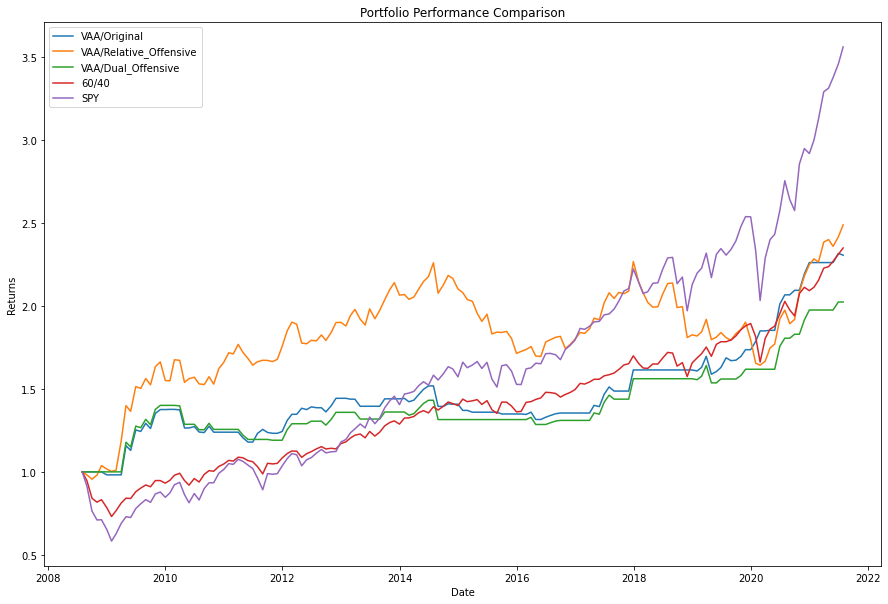

In [25]:
plt.figure(figsize=(15,10))
plt.plot(combined_df)
plt.legend(combined_df.columns)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Portfolio Performance Comparison')

### Backtesting Performance Comparison (Original VAA, 60/40, SPY)

Text(0.5, 1.0, 'Portfolio Performance Comparison')

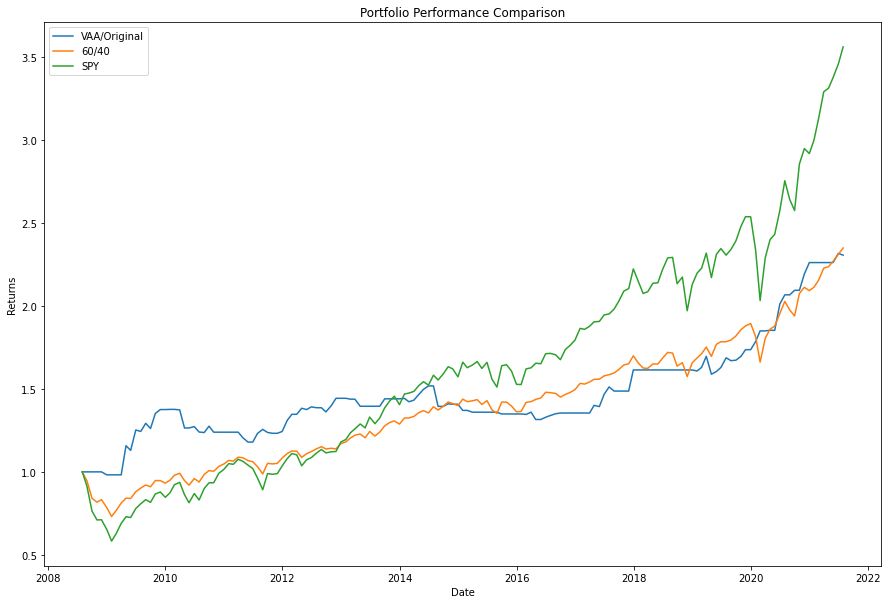

In [26]:
sub_df = combined_df[['VAA/Original', '60/40', 'SPY']]
plt.figure(figsize=(15,10))
plt.plot(sub_df)
plt.legend(sub_df.columns)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Portfolio Performance Comparison')

## Investment decision based on strategy algorithm

In [27]:
offensive_momentum

,1M,3M,6M,12M,Score
SPY,0.029760,0.075040,0.187191,0.292720,1.324382
VEA,0.013132,0.000763,0.092689,0.252926,0.598946
VWO,0.021914,-0.030624,-0.004953,0.181942,0.312503
AGG,-0.003435,0.013182,0.006242,-0.019515,0.004482


In [28]:
defensive_momentum

,1M,3M,6M,12M,Score
SHY,-0.000464,-0.000811,-0.000811,-0.003581,-0.014010
IEF,-0.004588,0.024213,0.012180,-0.035717,0.030446
LQD,-0.005220,0.027257,0.022908,-0.002212,0.089988


In [29]:
if (offensive_momentum['Score'] < 0).any():
    if (defensive_momentum['Score'] < 0).any():
        print('hold cash')
    else:
        first = defensive_momentum.sort_values(by='Score', ascending=False).index[0]
        print('invest in ' + first)
else:
    first = offensive_momentum.sort_values(by='Score', ascending=False).index[0]
    print('invest in ' + first)

invest in SPY
